In this Notebook, data from paleoclimate simulations with the CLIMBER-X Earth System Model ([Willeit et al. 2022](https://doi.org/10.5194/gmd-15-5905-2022)) are analysed. The simulations represent the Late Triassic to Early Jurassic periods (230 to 190 million years ago). In these experiments, the climate model was exposed to an idealized orbital forcing to study the effects of astronomical cycles on global and regional climate conditions. 

Such orbital cycles result from the gravitaional interaction of the planets in the solar system and cause periodic changes in the elliptical shape of Earth's orbit ("eccentricity"), the tilt of Earth's rotation axis ("obliquity") and the timing of the seasons relative to the time when Earth's distance to the sun reaches its minimum (perihelion) and maximum (aphelion) ("precession"). These mechanisms particularly cause changes in the seasonal and latitudinal distribution of solar radiation received by the Earth and exhibit main periodicities typically around 405$\,$000, 100$\,$000, 41$\,$000 and 21$\,$000 kyr.

The fundamental climatic effects of orbital cycles are demonstrated by the transitions between glacial and interglacial states during the past 3 million years. However, the underlying processes have been active also during earlier periods in the history of life on Earth. Landwehrs et al. 2022 used the climate simulations presented here to interpret the sedimentary record of the Newark-Hartford basins in the eastern US in terms of an orbital climate forcing. This archive provides an exceptional record of cyclic variations of lake depths that are linked to an astronomical moulation of climate, and the regional precipitation--evaporation balance in particular.



# Preparations

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean
import numpy as np
import cartopy.crs as ccrs
import xarray as xr
import glob
import pandas as pd

In [2]:
### Collect basic information on the available simulation runs
### This is a small sample of the data set provided by Landwehrs et al. 2022.

paths=sorted(glob.glob('./data/???Ma_*Marcilly2021')) 
### (these simulations used the paleogeogrpahic reconstruction of Marcilly et al. 2021, doi.org/10.1016/j.gr.2021.05.016)
    
runs_df=pd.DataFrame([], columns=['age','pCO2','run'], index=paths) 
    
for path in runs_df.index:
    run=path[path.rfind('/')+1:]     
    idx_Ma=run.find('Ma')
    age=int(run[idx_Ma-3:idx_Ma])
    idx_ppm=run.find('ppm')
    pCO2=int(run[idx_ppm-4:idx_ppm])      
        
    runs_df.loc[path]=age,pCO2,run 
    
runs_df['path']=list(runs_df.index)    
runs_df=runs_df.set_index('run')


# Seasonal Atmospheric circulation and Monsoon Patterns

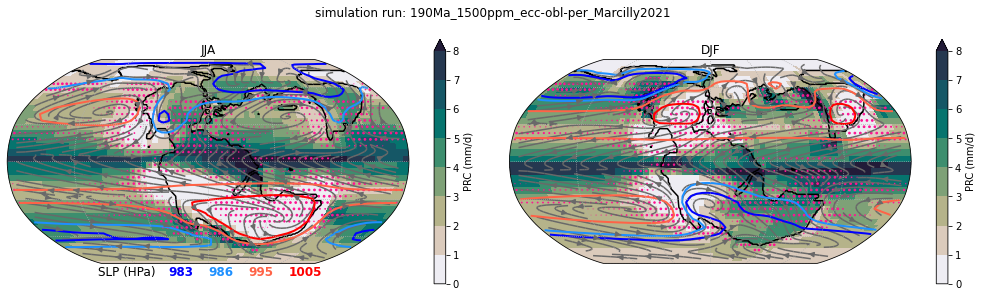

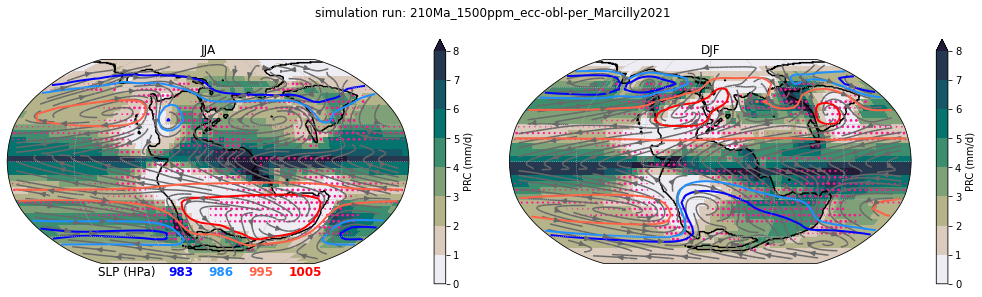

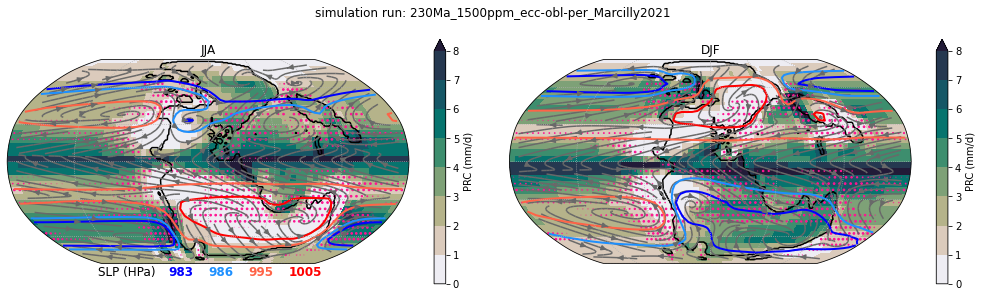

In [3]:

### to identify monsoonal conditions based wet and dry season precipitation, following Wang et al. 2014 (doi.org/10.5194/cp-10-2007-2014)
def func_condi_monsoon(prc_wet_NHSH,prc_dry_NHSH,prc_ann,temp_min):
    prc_wetdry_NHSH=prc_wet_NHSH-prc_dry_NHSH
    ### precipitation difference between wet and dry season should be more than 2 mm/d
    condi_monsoon_1=(prc_wetdry_NHSH>=2) 
    ### more than 55% of annual precipiation should fall during wet season
    condi_monsoon_2=(((prc_wet_NHSH*5*30)/(prc_ann*12*30))>=0.55) 
    ### exclude regions with monthly minimum temperature <0°C, because the monsoon concept
    ### traditionally applies to warm tropical, or sub-tropical regions
    condi_monsoon_T=(temp_min>0)
    condi_monsoon=(condi_monsoon_1 & condi_monsoon_2 & condi_monsoon_T)   
    return condi_monsoon

### loop over the geologic timeslices for which climate model data is included and analyzed/plotted here
for run in runs_df.index: 

    [age,path,pCO2]=runs_df.loc[run, ['age','path','pCO2']]#[0]    
    age_str='{:03}'.format(age)
    
    fig,axs=plt.subplots(1,2,subplot_kw={'projection': ccrs.Robinson()},facecolor='w',figsize=(18,4.5))

    ### open the NetCDF file containing model output for the atmosphere
    ### contains monthly data on a 5°x5° horizontal grid for 200 time steps representing 200,000 model years
    ds=xr.open_dataset('./data/{}'.format(run)+'/atm.nc')

    ### calculate the average reference climate state over all included time steps
    ds_ref=ds.mean(dim=['time']) 
    
    prc=ds.prc.isel(mon=slice(0,11+1,1)) ### extract monthly precipitation
    prc_pad=prc.pad(mon=2,mode='wrap') ### pad for rolling mean
    prc_roll=prc_pad.rolling(mon=5,center=True).mean() ### rolling mean for five consecutive months values
    
    ### determining min./max. values of precipitation in 5 months windows, separately for northern and southern hemisphere
    ### this is to determine wet/dry season precipitation levels to check for monsoonal conditions
    prc_roll_NH=prc_roll.where(prc_roll.lat>0)
    prc_roll_SH=prc_roll.where(prc_roll.lat<0)
    prc_wet_NH=prc_roll_NH.max(dim='mon').fillna(0)
    prc_wet_SH=prc_roll_SH.max(dim='mon').fillna(0)
    prc_dry_NH=prc_roll_NH.min(dim='mon').fillna(0)
    prc_dry_SH=prc_roll_SH.min(dim='mon').fillna(0)
    ### combine wet/dry season precipitation values of northern and southern hemisphere
    prc_wet_NHSH=prc_wet_NH+prc_wet_SH 
    prc_dry_NHSH=prc_dry_NH+prc_dry_SH 
    ### difference between wet and dry season precipitation
    prc_wetdry_NHSH=prc_wet_NHSH-prc_dry_NHSH
    
    prc_ann=prc.mean(dim='mon')
    temp_min=ds.t2a.isel(mon=slice(0,11+1,1)).min(dim='mon')-273.15
    monsoon_intensity=(prc_wet_NHSH-prc_dry_NHSH)/prc_ann    
    
    prc_ref=ds_ref.prc
    prc_ref_ann=ds_ref.prc.isel(mon=-1)
    prc_ref_wet_NHSH=prc_wet_NHSH.mean(dim=['time']) 
    prc_ref_dry_NHSH=prc_dry_NHSH.mean(dim=['time'])    
    temp_ref_min=ds_ref.t2a.isel(mon=slice(0,11+1,1)).min(dim='mon')-273.15    
    
    ### evaluate the obtained wet/dry season precipitation against the monsoon conditions defined above
    ### this is done for the conditions at each of the 200 time steps, because the orbital forcing changes the climate
    condi_monsoon_times=func_condi_monsoon(prc_wet_NHSH,prc_dry_NHSH,prc_ann,temp_min)
    condi_monsoon_anytime=condi_monsoon_times.any(dim='time')
    condi_monsoon_ref=func_condi_monsoon(prc_ref_wet_NHSH,prc_ref_dry_NHSH,prc_ref_ann,temp_ref_min)
    
    ### determine seasonal values for JJA (June-July-August) and DJF (December-January-February)
    ds_JJA=ds_ref.isel(mon=[5,6,7]).mean(dim=['mon'])
    ds_DJF=ds_ref.isel(mon=[11,0,1]).mean(dim=['mon'])

    ### get information on the paleogeography implemented in this simulation to plot the land-sea mask in the maps
    ds_geo=xr.open_dataset(path+'/geo.nc')
    lo_mask=(ds_geo.z_bed.isel(time=-1)>0)
    
    ### plot the land-sea mask
    for aa in axs[:]:
        lo_mask.plot.contour(ax=aa,transform=ccrs.PlateCarree(),levels=[0.5],colors='k');
    
    ### plot the JJA and DJF precipitation
    cscale=8   
    p_cbar=ds_JJA['prc'].plot(ax=axs[0],transform=ccrs.PlateCarree(),cmap=cmocean.cm.rain,vmin=0,vmax=cscale,levels=int(cscale+1),
                                  add_colorbar=True,cbar_kwargs={'label':'PRC (mm/d)'}) 
    ds_DJF['prc'].plot(ax=axs[1],transform=ccrs.PlateCarree(),cmap=cmocean.cm.rain,vmin=0,vmax=cscale,levels=int(cscale+1),
                           add_colorbar=True,cbar_kwargs={'label':'PRC (mm/d)'}) 
    gl0=axs[0].gridlines(linestyle=':')     
    gl1=axs[1].gridlines(linestyle=':')     
    
    ### plot the occurrence of monsoonal conditions as dots.
    ### the size of the dots scales with the number of time steps, or orbital configurations, for which monsoonal conditions occur in a given grid cell
    ### some regions exhibit monsoonal characteristics at all times, while others do only for certain orbital configurations, 
    ### e.g. when seasonality is maximized at the respective hemisphere
    var=(1*(condi_monsoon_times)).sum(dim='time')
    var=3*var/var.max()
    X,Y=np.meshgrid(var.lon,var.lat)
    axs[0].scatter(X,Y,s=var.data,c='deeppink',transform=ccrs.PlateCarree())
    axs[1].scatter(X,Y,s=var.data,c='deeppink',transform=ccrs.PlateCarree())

    ### plot the wind directions from the simulated meridional and zonal wind velocities (us and vs respectively)
    ds_JJA.plot.streamplot(x='lon',y='lat',u='us',v='vs',ax=axs[0],transform=ccrs.PlateCarree(),color='dimgrey',density=1.5)
    ds_DJF.plot.streamplot(x='lon',y='lat',u='us',v='vs',ax=axs[1],transform=ccrs.PlateCarree(),color='dimgrey',density=1.5)
    
    ### plot sea level pressure (SLP) to indicate major high and low pressure systems
    slp_levs=[983e2,986e2,995e2,1005e2]
    slp_cols=['b','dodgerblue','tomato','r']
    ds_JJA.slp.plot.contour(ax=axs[0],levels=slp_levs,colors=slp_cols,transform=ccrs.PlateCarree(),linewidths=2)
    ds_DJF.slp.plot.contour(ax=axs[1],levels=slp_levs,colors=slp_cols,transform=ccrs.PlateCarree(),linewidths=2)

    axs[0].text(0.225,-0.01,'SLP (HPa)',va='top',ha='left',fontsize=12,transform=axs[0].transAxes)
    for ll in range(len(slp_levs)):
        axs[0].text(0.4+ll*0.1,-0.01,'{}'.format(int(slp_levs[ll]/100)),color=slp_cols[ll],va='top',ha='left',fontsize=12,fontweight='bold',transform=axs[0].transAxes)

    fig.suptitle('simulation run: {}'.format(run),y=0.98)
    axs[0].set_title('JJA')
    axs[1].set_title('DJF')   

    plt.subplots_adjust(wspace=0.0)
    # fig.savefig('./Plots_MesoOrb-Newark/MesoOrb-Newark_rev1_maps_monsoon+SLP+wind_{}to{}Ma_Cao201718.pdf'.format(ages_plot[0],ages_plot[-1]),bbox_inches='tight', dpi=900)#

# Modulation of Surface Temperature Seasonality by Astronomical Cycles

<ipython-input-7-d30a4a43e1f5>:56: RuntimeWarning: divide by zero encountered in true_divide
  fft_periods = np.around(1./fft_freqs)
<ipython-input-7-d30a4a43e1f5>:56: RuntimeWarning: divide by zero encountered in true_divide
  fft_periods = np.around(1./fft_freqs)
<ipython-input-7-d30a4a43e1f5>:56: RuntimeWarning: divide by zero encountered in true_divide
  fft_periods = np.around(1./fft_freqs)


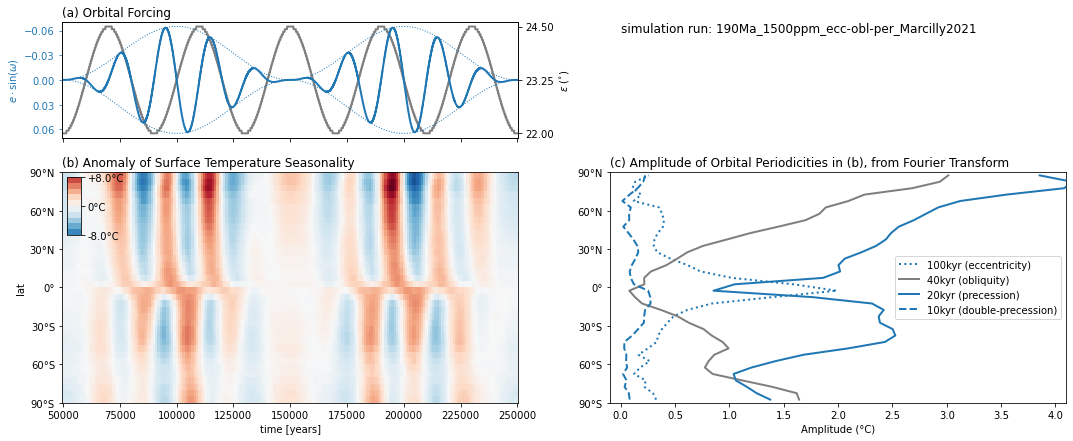

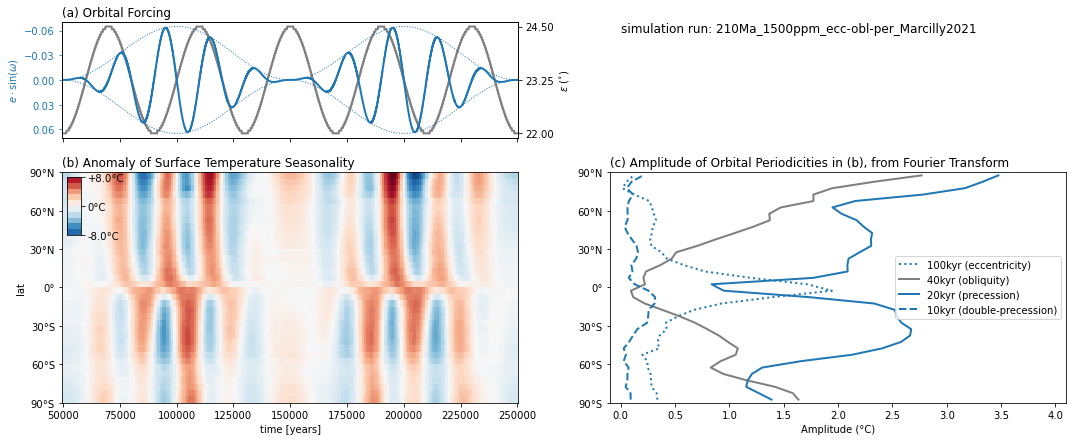

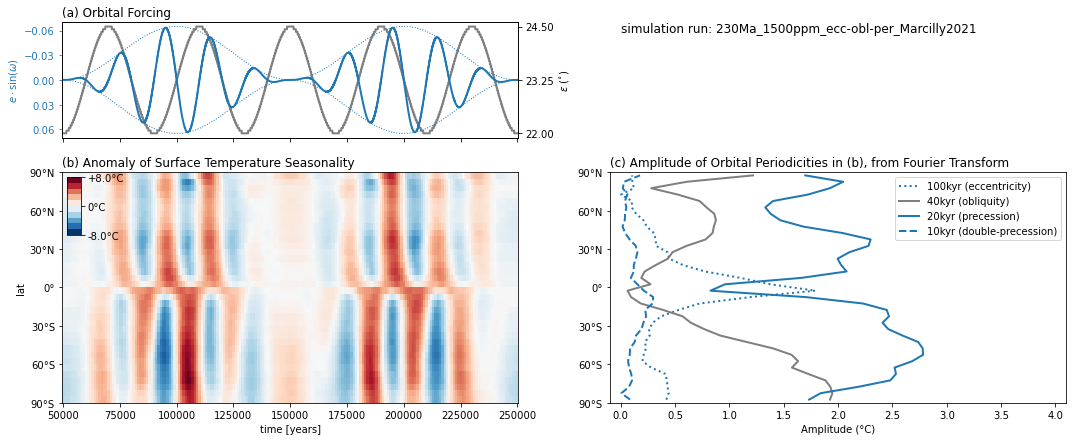

In [7]:
### loop over the geologic timeslices for which climate model data is included and analyzed/plotted here
for run in runs_df.index: 

    [age,path,pCO2]=runs_df.loc[run, ['age','path','pCO2']]#[0]    
    age_str='{:03}'.format(age)
    
    fig,axs=plt.subplots(2,2,facecolor='w',figsize=(18,7), gridspec_kw={'height_ratios': [0.5,1]},sharex='col') #,subplot_kw={'projection': ccrs.Robinson()}
    axs[0,1].axis('off')
    axs00_twin=axs[0,0].twinx()    
    
    ### open the orbital forcing file used to drive the climate model simulations
    ### this includes information how the eccentricity, obliquity and precession angle vary periodically over time
    ds_forcing=xr.open_dataset('./data/orbital_forcing.nc')    
    
    ### plot the orbital forcing parameters
    axs[0,0].plot(ds_forcing.time,ds_forcing.ecc*np.sin(ds_forcing.per*np.pi/180),c='tab:blue',lw=2)
    axs00_twin.plot(ds_forcing.time,ds_forcing.obl,c='tab:grey',lw=2)
    axs[0,0].plot(ds_forcing.time,ds_forcing.ecc,c='tab:blue',lw=1.,ls=':')
    axs[0,0].plot(ds_forcing.time,-1.*ds_forcing.ecc,c='tab:blue',lw=1.,ls=':')

    ### open the NetCDF file containing model output for the atmosphere
    ### contains monthly data on a 5°x5° horizontal grid for 200 time steps representing 200,000 model years
    ds=xr.open_dataset('./data/{}'.format(run)+'/atm.nc')

    ### calculate the average reference climate state over all included time steps
    ds_ref=ds.mean(dim=['time'])
    
    ### extract the simulated air temperatures at 2m height
    t2a=ds.t2a.isel(mon=slice(0,11+1,1))-273.15
    t2a_ref=ds_ref.t2a.isel(mon=slice(0,11+1,1))-273.15
     
    ### calculate the temperature seasonality as the difference between the hottest and coldest months
    t2a_seasonality_times= t2a.max(dim='mon')-t2a.min(dim='mon')
    t2a_seasonality_ref  = t2a_ref.max(dim='mon')-t2a_ref.min(dim='mon')    
    ### calculate the anomaly of the temperature seasonality with respect to the long-term average reference
    t2a_seasonality_anomaly=t2a_seasonality_times-t2a_seasonality_ref
    ### calculate the zonal mean 
    t2a_seasonality_anomaly_zonal=t2a_seasonality_anomaly.mean(dim='lon')
        
    ### plot the zonal mean temperature seasonality anomaly over time
    ### this illustrates how the orbital insolation forcing periodically modulates the seasons on the northern and southern hemisphere
    cscale=8   
    p_cbar=t2a_seasonality_anomaly_zonal.plot(ax=axs[1,0],x='time',y='lat',add_colorbar=False) 
    cbaxes = inset_axes(axs[1,0], width="3%", height="25%", loc='upper left') 
    vmin=-8 #t2a_seasonality_anomaly_zonal.min().data
    vmax=8 #t2a_seasonality_anomaly_zonal.max().data
    vdel=(vmax-vmin)/10
    cbar=fig.colorbar(p_cbar, cax=cbaxes, orientation='vertical', ticks=[vmin,0,vmax], boundaries=np.arange(vmin,vmax+vdel,vdel)) 
    cbar.ax.set_yticklabels(['{:+.1f}°C'.format(vmin),'0°C','{:+.1f}°C'.format(vmax)])

    ### perform a Fourier analysis of the zonal mean surface temperature anomaly
    ### this illustrates how strongly temperatures at different latitudes responde to the different orbital forcing parameters
    times=t2a_seasonality_anomaly_zonal.time.data[1:]
    N=times.size
    fft_freqs = np.fft.rfftfreq(N, times[1]-times[0])
    fft_periods = np.around(1./fft_freqs)
    fft=np.fft.rfft(t2a_seasonality_anomaly_zonal.data[1:,:],axis=0).transpose()
    t2a_seasonality_fft = 2.0/N * np.abs(fft) 

    ### we evaluate the obtained FFT spectrum at the 4 periods that are included in the orbital forcing
    periods_orb=np.asarray([100e3,40e3,20e3,10e3],dtype=int) ### in years  
    cols_orb=['tab:blue','tab:grey','tab:blue','tab:blue']
    linestyles_orb=[':','-','-','--']
    labels_orb=['eccentricity','obliquity','precession','double-precession']

    ### plot the amplitudes of surface temperature anomaly oscillations for the 4 periodicities at each latitude
    for period_idx,period_orb in enumerate(periods_orb):
        axs[1,1].plot(t2a_seasonality_fft[:,np.where(fft_periods==period_orb)[0][0]],t2a_seasonality_anomaly_zonal.lat.data,
                      label='{}kyr ({})'.format(int(period_orb/1e3),labels_orb[period_idx]),
                     c=cols_orb[period_idx],ls=linestyles_orb[period_idx],lw=2)
    axs[1,1].legend()
    
        
    for aa in [axs[0,0]]:
        aa.set_ylim((-0.07,0.07))
        aa.set_yticks([-0.06,-0.03,0,0.03,0.06])
    for aa in [axs00_twin]:
        aa.set_ylim((21.9,24.6))
        aa.set_yticks([22,23.25,24.5])
    axs[0,0].tick_params(axis='y', colors='tab:blue')

    axs[0,0].set_zorder(1)  
    axs[0,0].patch.set_visible(False)  
    
    axs[0,0].invert_yaxis()
    axs[0,0].set_ylabel('$e\cdot$sin($\omega$)',c='tab:blue')
    axs00_twin.set_ylabel('$\epsilon$ $\mathsf{(^{\circ})}$',c='k')  
    
    for aa in axs[1,:]:
        aa.set_ylim(-90,90)
        aa.set_yticks(np.arange(-90,90+30,30))
        aa.set_yticklabels(['90°S','60°S','30°S','0°','30°N','60°N','90°N'])
        
    axs[1,1].set_xlim([-0.1,4.1])
    
    axs[1,1].set_xlabel('Amplitude (°C)')
    
    axs[0,1].text(0,1,'simulation run: {}'.format(run),va='top',ha='left',fontsize=12)
    axs[0,0].set_title('(a) Orbital Forcing',loc='left')
    axs[1,0].set_title('(b) Anomaly of Surface Temperature Seasonality',loc='left')
    axs[1,1].set_title('(c) Amplitude of Orbital Periodicities in (b), from Fourier Transform',loc='left')    
